### Import libraries

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.utils import resample, shuffle
%matplotlib inline

### Read and filter data from bigquerry
Get all the Pizza restaurants data after 2012-01-01.

In [62]:
client = Client()

query = """SELECT r.text, r.stars, r.date,
                  b.categories, b.city, b.state, b.is_open
            FROM `valiant-song-371916.yelp.reviews` as r
            INNER JOIN `valiant-song-371916.yelp.business` as b
            ON b.business_id = r.business_id
            WHERE regexp_contains(categories, '(?i)(Restaurants)')
            AND regexp_contains(categories, '(?i)(Pizza)')
            AND DATE(r.date) >= '2012-01-01'
"""

reviews = client.query(query).to_dataframe()

In [63]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443436 entries, 0 to 443435
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   text        443436 non-null  object             
 1   stars       443436 non-null  float64            
 2   date        443436 non-null  datetime64[ns, UTC]
 3   categories  443436 non-null  object             
 4   city        443436 non-null  object             
 5   state       443436 non-null  object             
 6   is_open     443436 non-null  Int64              
dtypes: Int64(1), datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 24.1+ MB


In [64]:
reviews.isna().sum()

text          0
stars         0
date          0
categories    0
city          0
state         0
is_open       0
dtype: int64

In [65]:
reviews.head(5)

,text,stars,date,categories,city,state,is_open
0,What is happening at Ralph's? Their pizza is ...,2.0,2020-08-31 01:19:16+00:00,"Sandwiches, Restaurants, Pizza, Italian",Haddon Heights,NJ,1
1,First time in Indianapolis and first time here...,2.0,2021-06-07 11:42:25+00:00,"American (Traditional), Bars, Sandwiches, Nigh...",Fishers,IN,1
2,I ordered a large half pepperoni and half chee...,2.0,2019-07-13 20:49:32+00:00,"Restaurants, Pizza",Trenton,NJ,1
3,The boyfriend loved it but I was not a fan of ...,2.0,2013-10-09 19:51:19+00:00,"Restaurants, Pizza",Wynnewood,PA,0
4,I grew up eating at this place at least once a...,2.0,2015-02-21 02:36:54+00:00,"Restaurants, Pizza",Bryn Mawr,PA,0


### Data Exploration

5.0    194049
4.0     96732
1.0     68176
3.0     45769
2.0     38710
Name: stars, dtype: int64


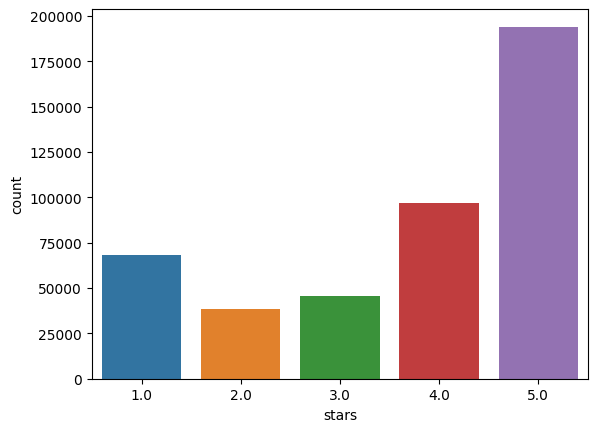

In [66]:
sns.countplot(x = reviews['stars'])
print(reviews['stars'].value_counts())

Create a sentiment feature based on the rating

In [67]:
reviews['sentiment']= reviews['stars'].apply(lambda x: 0 if x<=3 else 1)

In [68]:
reviews.head(3)

,text,stars,date,categories,city,state,is_open,sentiment
0,What is happening at Ralph's? Their pizza is ...,2.0,2020-08-31 01:19:16+00:00,"Sandwiches, Restaurants, Pizza, Italian",Haddon Heights,NJ,1,0
1,First time in Indianapolis and first time here...,2.0,2021-06-07 11:42:25+00:00,"American (Traditional), Bars, Sandwiches, Nigh...",Fishers,IN,1,0
2,I ordered a large half pepperoni and half chee...,2.0,2019-07-13 20:49:32+00:00,"Restaurants, Pizza",Trenton,NJ,1,0


In [69]:
#Filter the dataset to contain only the text and sentiment values
sent_df = reviews[['text','sentiment']]
sent_df.head()

,text,sentiment
0,What is happening at Ralph's? Their pizza is ...,0
1,First time in Indianapolis and first time here...,0
2,I ordered a large half pepperoni and half chee...,0
3,The boyfriend loved it but I was not a fan of ...,0
4,I grew up eating at this place at least once a...,0


1    290781
0    152655
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

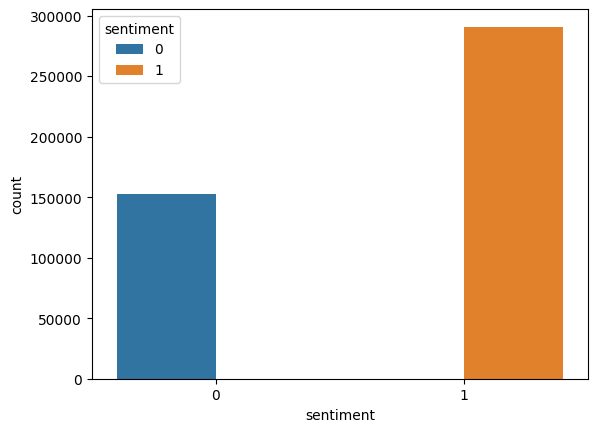

In [70]:
#check values of sentiments:
print(sent_df['sentiment'].value_counts())
sns.countplot(data=sent_df, x="sentiment", hue="sentiment")

In [71]:
#downsampling the possitive comments: 
n_samples_neg= len(sent_df[sent_df['sentiment']==0])
pos_sent_df = resample(sent_df[sent_df['sentiment']==1],
                       replace = False,
                       n_samples = n_samples_neg,
                       random_state = 100)
print(n_samples_neg, len(pos_sent_df))

152655 152655


In [72]:
#combine the dataset:
df = shuffle(pd.concat([pos_sent_df, sent_df[sent_df['sentiment']==0]]),
             random_state = 100)

0    152655
1    152655
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

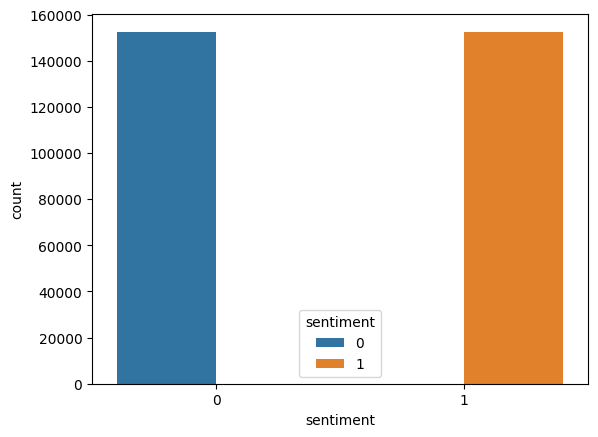

In [73]:
#check values of sentiments:
print(df['sentiment'].value_counts())
sns.countplot(data=df, x="sentiment", hue="sentiment")

<AxesSubplot:xlabel='sentiment', ylabel='len_text'>

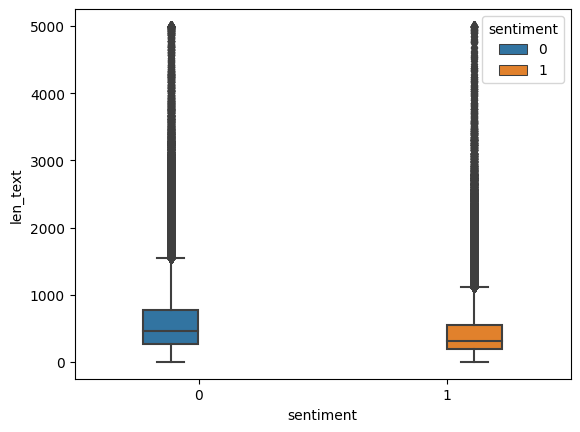

In [74]:
df['len_text'] = df['text'].apply(lambda x: len(x))
sns.boxplot(data = df, y='len_text',x='sentiment',hue='sentiment',width=0.45)

<AxesSubplot:xlabel='len_text', ylabel='Proportion'>

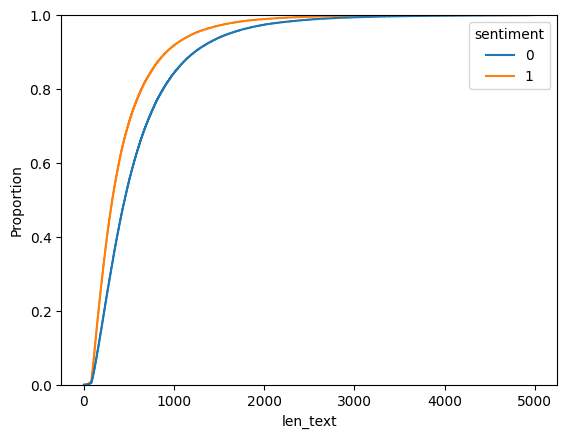

In [75]:
sns.ecdfplot(data = df, x='len_text', hue = 'sentiment')

### Data Preprocessing

#### NLP library

In [116]:
import nltk
from nltk.corpus import stopwords
import re, string
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from string import punctuation 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, cosine_similarity

#ML model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [78]:
#!pip install xgboost

In [19]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

#### Text normalization

In [79]:
#Remove stopwords and punctuation:
stopwords_en = set(stopwords.words('english'))
punctuation_en = set(punctuation)
stopwords_with_punct = stopwords_en.union(punctuation_en)

def tag_converter(wtag):
        """ Converts Penn Treebank tags to WordNet. """
        tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
        try:
            return tag[wtag[:2]]
        except:
            return 'n'
        
def text_normalizer(text, all_stopwords):

    #tokenization:
    allwords = word_tokenize(text)
    clean_words = []
    for w in allwords:
        if w not in all_stopwords:
            clean_words.append(w.lower()) #use only lower case

    #pos-tag (part-of-speech tagging - type of words: nound, adjectives, etc)
    clean_words_tag = pos_tag(clean_words)

    #Lemmatizer
    clean_words_lemmatized =[]
    wln = WordNetLemmatizer()
    
    for word_tag in clean_words_tag:
        clean_words_lemmatized.append(wln.lemmatize(word=word_tag[0],pos=tag_converter(word_tag[1])))

    return clean_words_lemmatized

In [80]:
### Test case:
original_text = df['text'][0:5]
normed_text = original_text.apply(lambda x: " ".join(text_normalizer(x, stopwords_with_punct)))
print('Original text:',list(original_text)[0])
print('\nCleaned text:', list(normed_text)[0])

Original text: My husband and I went on a Saturday night with friends. I was excited because the atmosphere was great and there were lots of people. (which is always a good sign ) This was a new experience for us since we had never been here before. I would say if you want to go here for a beer and atmosphere it's a great place. The waitstaff was friendly. I ordered the tenderloin which I did not like at all. My husband ordered a pizza which i would say was average. We enjoyed trying the different beers they crafted. Outside they had corn hole, jumbo Jenga and many picnic tables with live music. Music was great! We will go back another weekend to have beer and nachos with friends and listen to the music outside but we will not be going back for the food.

Cleaned text: my husband i go saturday night friend i excite atmosphere great lot people always good sign this new experience u since never i would say want go beer atmosphere 's great place the waitstaff friendly i order tenderloin i

In [81]:
#processed the dataset:
alltext_normed = df['text'].apply(lambda x: " ".join(text_normalizer(x, stopwords_with_punct)))

#### Train-test split

In [82]:
X = alltext_normed
y = df['sentiment']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,
                                                    random_state=100,stratify=y)

In [84]:
X_train.shape, X_test.shape

((213717,), (91593,))

In [145]:
data = {'X_train': list(X_train),
       'X_test':list(X_test),
       'y_train':list(y_train),
       'y_test':list(y_test)}

In [146]:
from google.cloud import storage
import json

# credentials to get access google cloud storage
# write your key path in place of gcloud_private_key.json
storage_client = storage.Client()

# write your bucket name in place of bucket1go
bucket_name = 'raw-data-yelp'
BUCKET = storage_client.get_bucket(bucket_name)

def create_json(json_object, filename):
    '''
    this function will create json object in
    google cloud storage
    '''
    # create a blob
    blob = BUCKET.blob(filename)
    # upload the blob 
    blob.upload_from_string(
        data=json.dumps(json_object),
        content_type='application/json'
        )
    result = filename + ' upload complete'
    return {'response' : result}

# your object
json_object = json.dumps(data)
# set the filename of your json object
filename = 'train-test-data-221219.json'

# run the function and pass the json_object
print(create_json(json_object, filename))

{'response': 'train-test-data-221219.json upload complete'}


#### Text Vectorization

In [100]:
cv = CountVectorizer(min_df=0.05, max_df=1.) #min_df=0.05 to remove 0.5% document frequency
X_train_vect = cv.fit_transform(X_train)
vocab = cv.get_feature_names() #all unique words
X_test_vect = cv.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [101]:
#View the first 100 reviews:
pd.DataFrame(X_train_vect[0:100].toarray(),columns =vocab).head(3)

,10,also,always,amaze,and,another,area,around,ask,atmosphere,...,way,we,well,when,wing,work,worth,would,year,you
0,0,1,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [102]:
X_train_vect.shape, X_test_vect.shape

((213717, 186), (91593, 186))

#### Normalized with tf-idf

In [103]:
#Transform a count matrix to a normalized tf-idf representation
tfi = TfidfTransformer(norm = 'l2',  use_idf=True, smooth_idf=True)
X_train_weighted = tfi.fit_transform(X_train_vect)
X_test_weighted = tfi.transform(X_test_vect)
X_train_weighted.shape,X_test_weighted.shape

((213717, 186), (91593, 186))

In [104]:
#View the first 100 reviews:
pd.DataFrame(X_train_weighted[0:100].toarray(),columns =vocab).head()

,10,also,always,amaze,and,another,area,around,ask,atmosphere,...,way,we,well,when,wing,work,worth,would,year,you
0,0.0,0.137958,0.0,0.0,0.176695,0.0,0.0,0.0,0.000000,0.0,...,0.162912,0.112540,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.250147,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.204058,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.304082,0.0,...,0.000000,0.000000,0.0,0.362758,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Machine Learning Models for Sentiment Analysis

#### Gaussian Naive Bayes
The model will estimate the propability that the review is positive or negative based on the frequency of words in the reviews occur in the train dataset with known sentiment. 
The naive assumption means that each word is conditionally independent, which neglects the word order, grammatical rules). Gaussian naive bayes model assumed that each class are distributed according to a normal (Gaussian) distribution.

In [106]:
model_gnb = GaussianNB()
model_gnb.fit(X_train_weighted.toarray(), y_train)

GaussianNB()

In [29]:
model_gnb_acc = cross_val_score(estimator=model_gnb, X=X_train_weighted.toarray(), y=y_train, cv=5, n_jobs=-1)
model_gnb_acc

array([0.80444039, 0.80713083, 0.80890438, 0.80803874, 0.80518447])

In [107]:
y_pred = model_gnb.predict(X_test_weighted.toarray())
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     45797
           1       0.80      0.82      0.81     45796

    accuracy                           0.81     91593
   macro avg       0.81      0.81      0.81     91593
weighted avg       0.81      0.81      0.81     91593



array([[36425,  9372],
       [ 8455, 37341]])

#### Support Vector Machines
Will take a very long time, reduce the number of training samples

In [108]:
small_X_train, small_y_train = resample(X_train_weighted, y_train, 
                                        random_state=5,
                                       n_samples = 10000,
                                       stratify = y_train)

In [109]:
small_X_train.shape,small_y_train.shape

((10000, 186), (10000,))

In [110]:
y_train.value_counts()

1    106859
0    106858
Name: sentiment, dtype: int64

In [111]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(small_X_train.toarray(),small_y_train)

SVC(kernel='linear')

In [112]:
y_pred = model_svm.predict(X_test_weighted.toarray())
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     45797
           1       0.84      0.83      0.83     45796

    accuracy                           0.84     91593
   macro avg       0.84      0.84      0.84     91593
weighted avg       0.84      0.84      0.84     91593



array([[38630,  7167],
       [ 7910, 37886]])

#### XGBoost

In [135]:
classifier = XGBClassifier(tree_method='gpu_hist')
model_xgb = classifier.fit(X_train_weighted.toarray(), y_train)

In [136]:
y_pred = model_xgb.predict(X_test_weighted.toarray())
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     45797
           1       0.85      0.84      0.84     45796

    accuracy                           0.84     91593
   macro avg       0.84      0.84      0.84     91593
weighted avg       0.84      0.84      0.84     91593



array([[38958,  6839],
       [ 7502, 38294]])

### Conclusions

1. SVM and XGBoost give a more accurate results than Gaussian Naive Bayes
2. SVM is extremely slow in large dataset and thus, the amount of train records was reduced to less than 10% original train dataset
3. XGBoost is fastest and yield similar results to SVM method and thus is a preferable algorithm in this study.
4. NLTK was used for text normalization, however, processing time is long and required for future optimization (e.g., i